In [198]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray as rioxr
import xarray as xr
from pyproj import CRS, Transformer
import ensaio
import harmonica as hm
from scipy.interpolate import griddata

### Cargar los datos tomados del campo gravitacional en la zona de estudio

In [199]:
# Nombre del archivo
filename = 'Datos_Gravimetria_AGCM.csv'

In [200]:
# Leer el archivo CSV
df = pd.read_csv(filename, sep=';')

### Calcular la gravedad teórica según el elipsode GRS80

In [201]:
df['GRS1980_(gt)'] = 978032.7 * (1 + 0.0053024*np.sin(np.deg2rad(df['Lat']))**2 - 0.0000058*np.sin(2*np.deg2rad(df['Lat']))**2
)

df

,Station,Long,Lat,X,Y,Z,G_Obs,GRS1980_(gt)
0,93,-75.4080,4.4427,4732883.463,2049345.170,1802.569,977628.5013,978063.682117
1,98,-75.3415,4.4585,4740260.711,2051069.569,2014.366,977621.7091,978063.902439
2,1000,-75.4053,4.5156,4733205.458,2057405.449,2127.088,977552.7659,978064.705131
3,1001,-75.4063,4.5073,4733091.517,2056492.891,1954.450,977583.5755,978064.587823
4,1002,-75.4071,4.5116,4733001.529,2056965.559,1981.408,977578.0543,978064.648571
...,...,...,...,...,...,...,...,...
131,3023,-75.3437,4.4639,4740019.008,2051673.049,2339.895,977519.8658,978063.977916
132,3024,-75.3415,4.4585,4740260.711,2051069.569,2014.666,977585.9545,978063.902439
133,3025,-75.3457,4.4563,4739795.423,2050836.891,2008.001,977588.4678,978063.871714
134,73124018,-75.4172,4.4422,4731859.783,2049294.485,1832.207,977623.5576,978063.675158


### Corrección de aire libre

In [202]:
# Definir la función de corrección por aire libre
def Correccion_por_aire_libre(Z): 
    return -0.3086 * (Z - 0)

# Aplicar la función a la columna Z
df['CA'] = Correccion_por_aire_libre(df['Z'])


df

,Station,Long,Lat,X,Y,Z,G_Obs,GRS1980_(gt),CA
0,93,-75.4080,4.4427,4732883.463,2049345.170,1802.569,977628.5013,978063.682117,-556.272793
1,98,-75.3415,4.4585,4740260.711,2051069.569,2014.366,977621.7091,978063.902439,-621.633348
2,1000,-75.4053,4.5156,4733205.458,2057405.449,2127.088,977552.7659,978064.705131,-656.419357
3,1001,-75.4063,4.5073,4733091.517,2056492.891,1954.450,977583.5755,978064.587823,-603.143270
4,1002,-75.4071,4.5116,4733001.529,2056965.559,1981.408,977578.0543,978064.648571,-611.462509
...,...,...,...,...,...,...,...,...,...
131,3023,-75.3437,4.4639,4740019.008,2051673.049,2339.895,977519.8658,978063.977916,-722.091597
132,3024,-75.3415,4.4585,4740260.711,2051069.569,2014.666,977585.9545,978063.902439,-621.725928
133,3025,-75.3457,4.4563,4739795.423,2050836.891,2008.001,977588.4678,978063.871714,-619.669109
134,73124018,-75.4172,4.4422,4731859.783,2049294.485,1832.207,977623.5576,978063.675158,-565.419080


### Anomalía de Aire Libre

In [203]:
df['AAL'] = df['G_Obs'] - df['GRS1980_(gt)'] - df['CA']


df

,Station,Long,Lat,X,Y,Z,G_Obs,GRS1980_(gt),CA,AAL
0,93,-75.4080,4.4427,4732883.463,2049345.170,1802.569,977628.5013,978063.682117,-556.272793,121.091976
1,98,-75.3415,4.4585,4740260.711,2051069.569,2014.366,977621.7091,978063.902439,-621.633348,179.440009
2,1000,-75.4053,4.5156,4733205.458,2057405.449,2127.088,977552.7659,978064.705131,-656.419357,144.480125
3,1001,-75.4063,4.5073,4733091.517,2056492.891,1954.450,977583.5755,978064.587823,-603.143270,122.130947
4,1002,-75.4071,4.5116,4733001.529,2056965.559,1981.408,977578.0543,978064.648571,-611.462509,124.868238
...,...,...,...,...,...,...,...,...,...,...
131,3023,-75.3437,4.4639,4740019.008,2051673.049,2339.895,977519.8658,978063.977916,-722.091597,177.979481
132,3024,-75.3415,4.4585,4740260.711,2051069.569,2014.666,977585.9545,978063.902439,-621.725928,143.777989
133,3025,-75.3457,4.4563,4739795.423,2050836.891,2008.001,977588.4678,978063.871714,-619.669109,144.265194
134,73124018,-75.4172,4.4422,4731859.783,2049294.485,1832.207,977623.5576,978063.675158,-565.419080,125.301522


In [204]:
from pyproj import CRS, Transformer

crs_src = CRS.from_string("EPSG:4326+3855")
crs_dst = CRS.from_epsg(4326)                # WGS84 3D (lon,lat, h_elipsoidal)
transformer = Transformer.from_crs(crs_src, crs_dst, always_xy=True)


lons = df['Long'].values
lats = df['Lat'].values
H_ortho_m = df['Z'].values

lon_out, lat_out, h_elip_m = transformer.transform(lons, lats, H_ortho_m)


height_geometric_m = h_elip_m

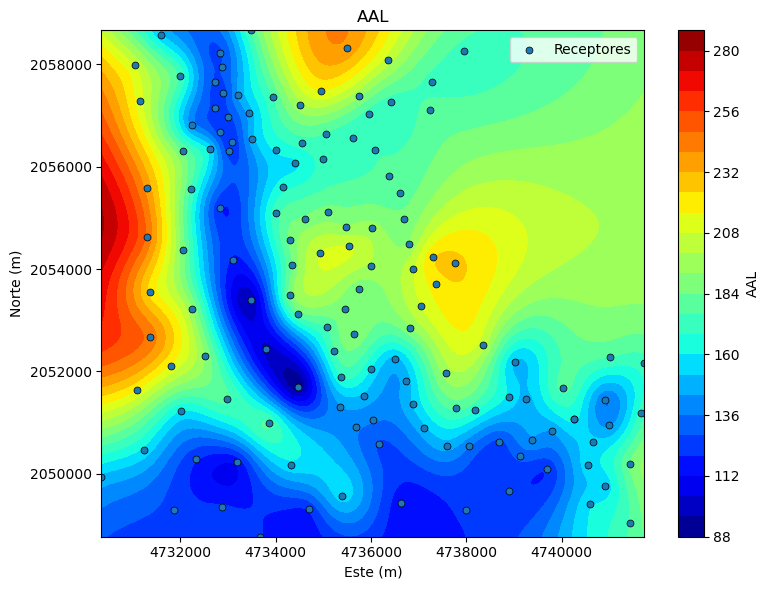

In [205]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator

data = df[['X', 'Y', 'AAL']].dropna()

X = data['X'].to_numpy()
Y = data['Y'].to_numpy()
XY = data[['X', 'Y']].to_numpy()
AAL = data['AAL'].to_numpy()

nx, ny = 300, 300  # resolución (sube/baja según rendimiento)
xi = np.linspace(XY[:, 0].min(), XY[:, 0].max(), nx)
yi = np.linspace(XY[:, 1].min(), XY[:, 1].max(), ny)
Xi, Yi = np.meshgrid(xi, yi)
xg = np.column_stack([Xi.ravel(), Yi.ravel()])

# RBF Thin Plate Spline (muy “suave”, parecido a min-curv)
rbf = RBFInterpolator(XY, AAL, kernel="thin_plate_spline", smoothing=1.0)
Z = rbf(xg).reshape(ny, nx)

plt.figure(figsize=(8,6))
im = plt.contourf(Xi, Yi, Z, levels=30, cmap='jet')


plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)

plt.colorbar(im, label='AAL')
plt.scatter(df['X'], df['Y'], s=25, edgecolor='k', linewidth=0.5, label='Receptores')
plt.xlabel('Este (m)'); plt.ylabel('Norte (m)')
plt.title('AAL')
plt.legend()
plt.tight_layout()
plt.show()


### Establecemos constantes utilizada para el cálculo de la densidad de Jung y para la Corrección de Bouguer

In [206]:
# Constantes
TWO_PI_G = 0.041916   # mGal/(m·g/cm^3)
FA = 0.3086           # mGal/m (por si lo necesitas luego)
rho0 = 2.67           # densidad inicial (g/cm^3) para el primer cálculo

# Referencia de altura
h0 = float(df["Z"].mean())
# h0 = 0
dH = df["Z"] - h0    # (h0 - h)  ← usamos esta convención, consistente con tu fórmula

# CB con densidad final (la pondremos en el paso 3 tras estimarla);
# de momento, si quieres ver CB con rho0:
TWO_PI_G * rho0 * dH


0     -48.542313
1     -24.838899
2     -12.223535
3     -31.544441
4     -28.527417
         ...    
131    11.592913
132   -24.805324
133   -25.551243
134   -45.225355
135   -49.145874
Name: Z, Length: 136, dtype: float64

In [207]:

CA = FA * dH
AAL = df["G_Obs"].values - df['GRS1980_(gt)'] - df['CA']     # Anomalía de aire libre
# ABS (cuando ya tengamos la densidad de Jung en el paso 3): ABS = AAL - CB


### Cálculo de la Corrección de Bouguer simple con Rho0 para el cálculo de la densidad base con el método de Jung

In [208]:
# Bouguer simple con rho0
BA0 = AAL - (TWO_PI_G * rho0 * dH)

# Jung (centrado, usando dH = (h0 - h))
x = (dH - dH.mean()).to_numpy()
y = (BA0 - BA0.mean()).to_numpy()
rho_jung = rho0 + np.sum(x*y) / (TWO_PI_G * np.sum(x**2))

# En estos datos, por convención de signos, el valor puede salir con signo negativo.
# Nos quedamos con la magnitud física:
rho_final = abs(rho_jung)

print("Densidad de reducción (Jung):", rho_final)


Densidad de reducción (Jung): 2.6300245002230516


### Cálculo de la Corrección de Bouguer Simple

In [209]:
CB = TWO_PI_G * rho_final * df['Z']
ABS = AAL - CB

# Si quieres añadir estas columnas a la tabla df:
df["dH_ref"]     = dH                 # (h0 - h)
df["CB"]    = CB
df["ABS"]   = ABS
df["rho_Jung"]   = rho_final  # mismo valor repetido en todas, si lo quieres visible

df


,Station,Long,Lat,X,Y,Z,G_Obs,GRS1980_(gt),CA,AAL,dH_ref,CB,ABS,rho_Jung
0,93,-75.4080,4.4427,4732883.463,2049345.170,1802.569,977628.5013,978063.682117,-556.272793,121.091976,-433.739897,198.715399,-77.623423,2.630025
1,98,-75.3415,4.4585,4740260.711,2051069.569,2014.366,977621.7091,978063.902439,-621.633348,179.440009,-221.942897,222.063923,-42.623914,2.630025
2,1000,-75.4053,4.5156,4733205.458,2057405.449,2127.088,977552.7659,978064.705131,-656.419357,144.480125,-109.220897,234.490409,-90.010283,2.630025
3,1001,-75.4063,4.5073,4733091.517,2056492.891,1954.450,977583.5755,978064.587823,-603.143270,122.130947,-281.858897,215.458777,-93.327830,2.630025
4,1002,-75.4071,4.5116,4733001.529,2056965.559,1981.408,977578.0543,978064.648571,-611.462509,124.868238,-254.900897,218.430630,-93.562392,2.630025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3023,-75.3437,4.4639,4740019.008,2051673.049,2339.895,977519.8658,978063.977916,-722.091597,177.979481,103.586103,257.950275,-79.970794,2.630025
132,3024,-75.3415,4.4585,4740260.711,2051069.569,2014.666,977585.9545,978063.902439,-621.725928,143.777989,-221.642897,222.096995,-78.319006,2.630025
133,3025,-75.3457,4.4563,4739795.423,2050836.891,2008.001,977588.4678,978063.871714,-619.669109,144.265194,-228.307897,221.362245,-77.097051,2.630025
134,73124018,-75.4172,4.4422,4731859.783,2049294.485,1832.207,977623.5576,978063.675158,-565.419080,125.301522,-404.101897,201.982696,-76.681173,2.630025


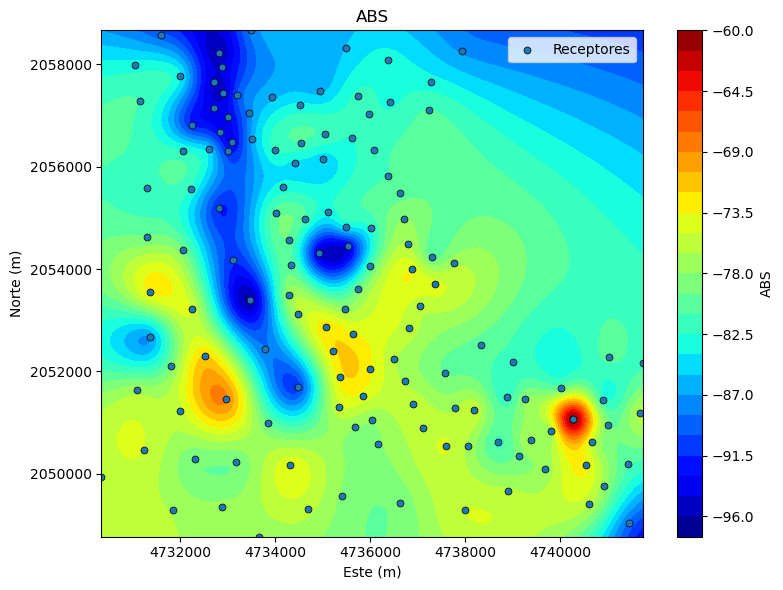

In [210]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator

data = df[['X', 'Y', 'ABS']].dropna()

X = data['X'].to_numpy()
Y = data['Y'].to_numpy()
XY = data[['X', 'Y']].to_numpy()
ABS = data['ABS'].to_numpy()

nx, ny = 300, 300  # resolución (sube/baja según rendimiento)
xi = np.linspace(XY[:, 0].min(), XY[:, 0].max(), nx)
yi = np.linspace(XY[:, 1].min(), XY[:, 1].max(), ny)
Xi, Yi = np.meshgrid(xi, yi)
xg = np.column_stack([Xi.ravel(), Yi.ravel()])

# RBF Thin Plate Spline (muy “suave”, parecido a min-curv)
rbf = RBFInterpolator(XY, ABS, kernel="thin_plate_spline", smoothing=1.0)
Z = rbf(xg).reshape(ny, nx)

plt.figure(figsize=(8,6))
im = plt.contourf(Xi, Yi, Z, levels=30, cmap='jet')


plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)

plt.colorbar(im, label='ABS')
plt.scatter(df['X'], df['Y'], s=25, edgecolor='k', linewidth=0.5, label='Receptores')
plt.xlabel('Este (m)'); plt.ylabel('Norte (m)')
plt.title('ABS')
plt.legend()
plt.tight_layout()
plt.show()

### Transformaciones para la corrección de Terreno

In [211]:
from pyproj import CRS, Transformer


G_Disturbance = df['G_Obs'] - ( df['GRS1980_(gt)'] + df['CA'] )

crs_src = CRS.from_string("EPSG:4326+3855")
crs_dst = CRS.from_epsg(4326)                # WGS84 3D (lon,lat, h_elipsoidal)
transformer = Transformer.from_crs(crs_src, crs_dst, always_xy=True)


lons = df['Long'].values
lats = df['Lat'].values
H_ortho_m = df['Z'].values

lon_out, lat_out, h_elip_m = transformer.transform(lons, lats, H_ortho_m)


height_geometric_m = h_elip_m

df

,Station,Long,Lat,X,Y,Z,G_Obs,GRS1980_(gt),CA,AAL,dH_ref,CB,ABS,rho_Jung
0,93,-75.4080,4.4427,4732883.463,2049345.170,1802.569,977628.5013,978063.682117,-556.272793,121.091976,-433.739897,198.715399,-77.623423,2.630025
1,98,-75.3415,4.4585,4740260.711,2051069.569,2014.366,977621.7091,978063.902439,-621.633348,179.440009,-221.942897,222.063923,-42.623914,2.630025
2,1000,-75.4053,4.5156,4733205.458,2057405.449,2127.088,977552.7659,978064.705131,-656.419357,144.480125,-109.220897,234.490409,-90.010283,2.630025
3,1001,-75.4063,4.5073,4733091.517,2056492.891,1954.450,977583.5755,978064.587823,-603.143270,122.130947,-281.858897,215.458777,-93.327830,2.630025
4,1002,-75.4071,4.5116,4733001.529,2056965.559,1981.408,977578.0543,978064.648571,-611.462509,124.868238,-254.900897,218.430630,-93.562392,2.630025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3023,-75.3437,4.4639,4740019.008,2051673.049,2339.895,977519.8658,978063.977916,-722.091597,177.979481,103.586103,257.950275,-79.970794,2.630025
132,3024,-75.3415,4.4585,4740260.711,2051069.569,2014.666,977585.9545,978063.902439,-621.725928,143.777989,-221.642897,222.096995,-78.319006,2.630025
133,3025,-75.3457,4.4563,4739795.423,2050836.891,2008.001,977588.4678,978063.871714,-619.669109,144.265194,-228.307897,221.362245,-77.097051,2.630025
134,73124018,-75.4172,4.4422,4731859.783,2049294.485,1832.207,977623.5576,978063.675158,-565.419080,125.301522,-404.101897,201.982696,-76.681173,2.630025


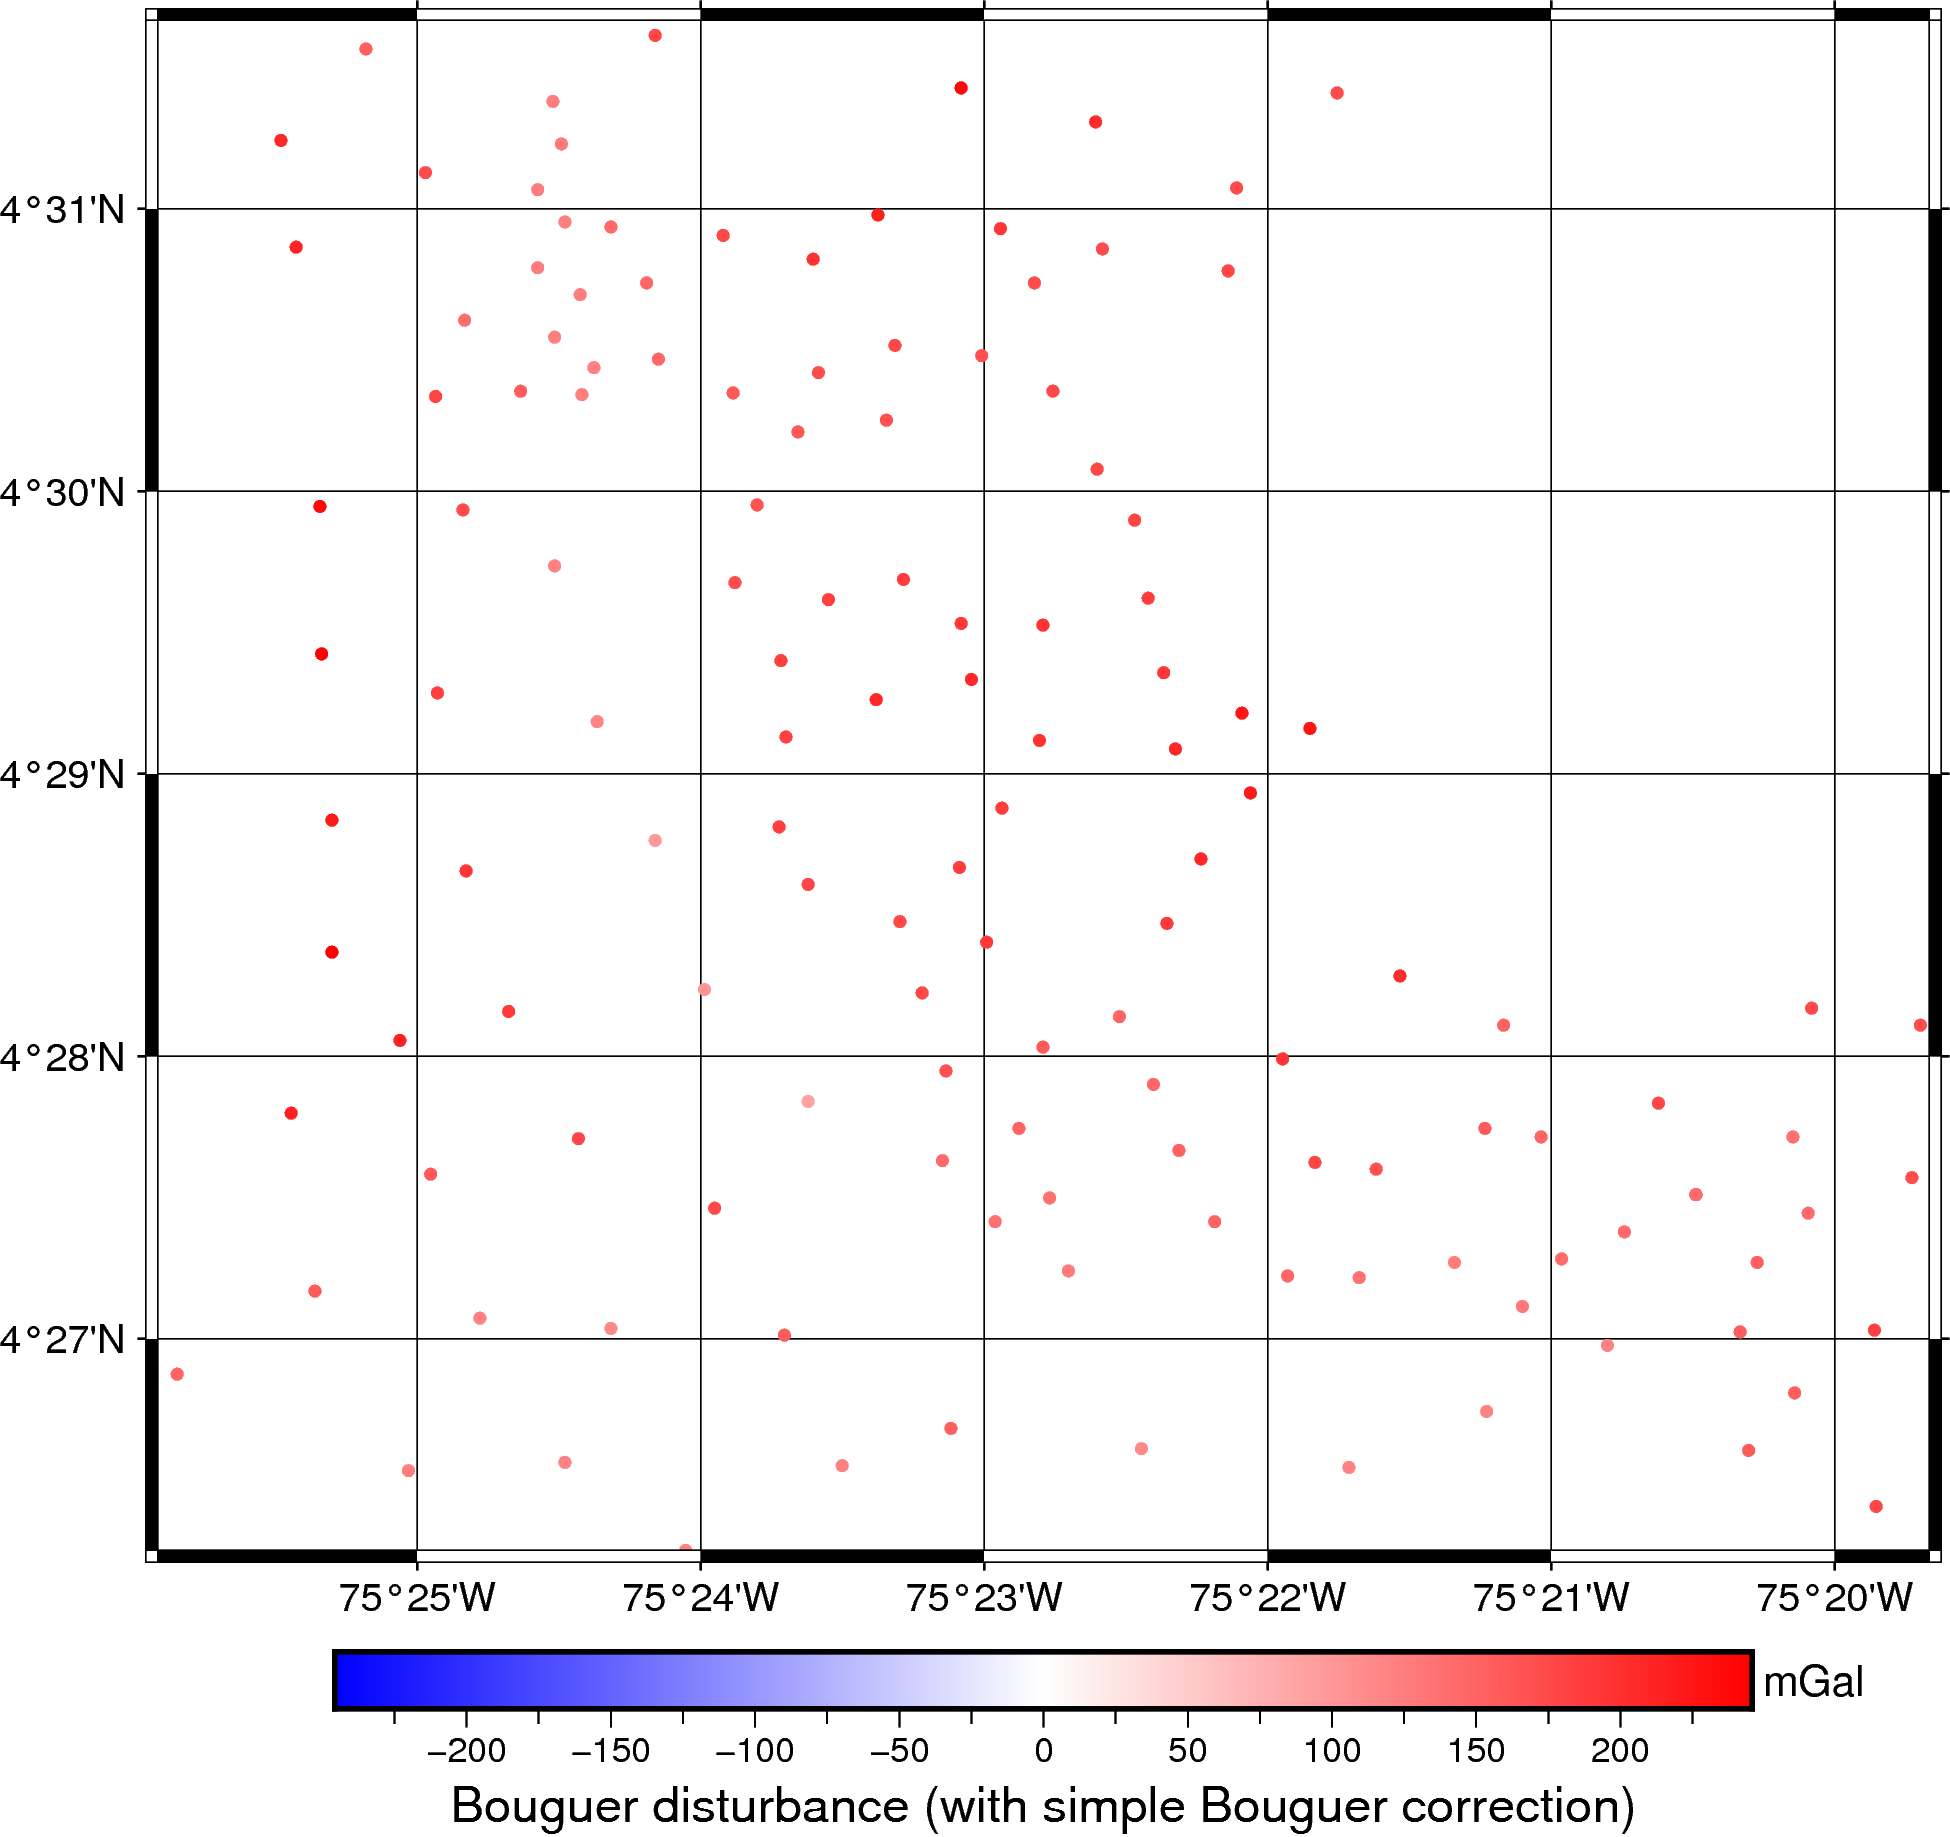

In [212]:
import pygmt
import verde as vd


maxabs = vd.maxabs(G_Disturbance)

fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.plot(
   x=lons,
   y=lats,
   fill=G_Disturbance,
   cmap=True,
   style="c3p",
   projection="M15c",
   frame=['ag', 'WSen'],
)
fig.colorbar(cmap=True, frame=["a50f25", "x+lBouguer disturbance (with simple Bouguer correction)", "y+lmGal"])
fig.show()

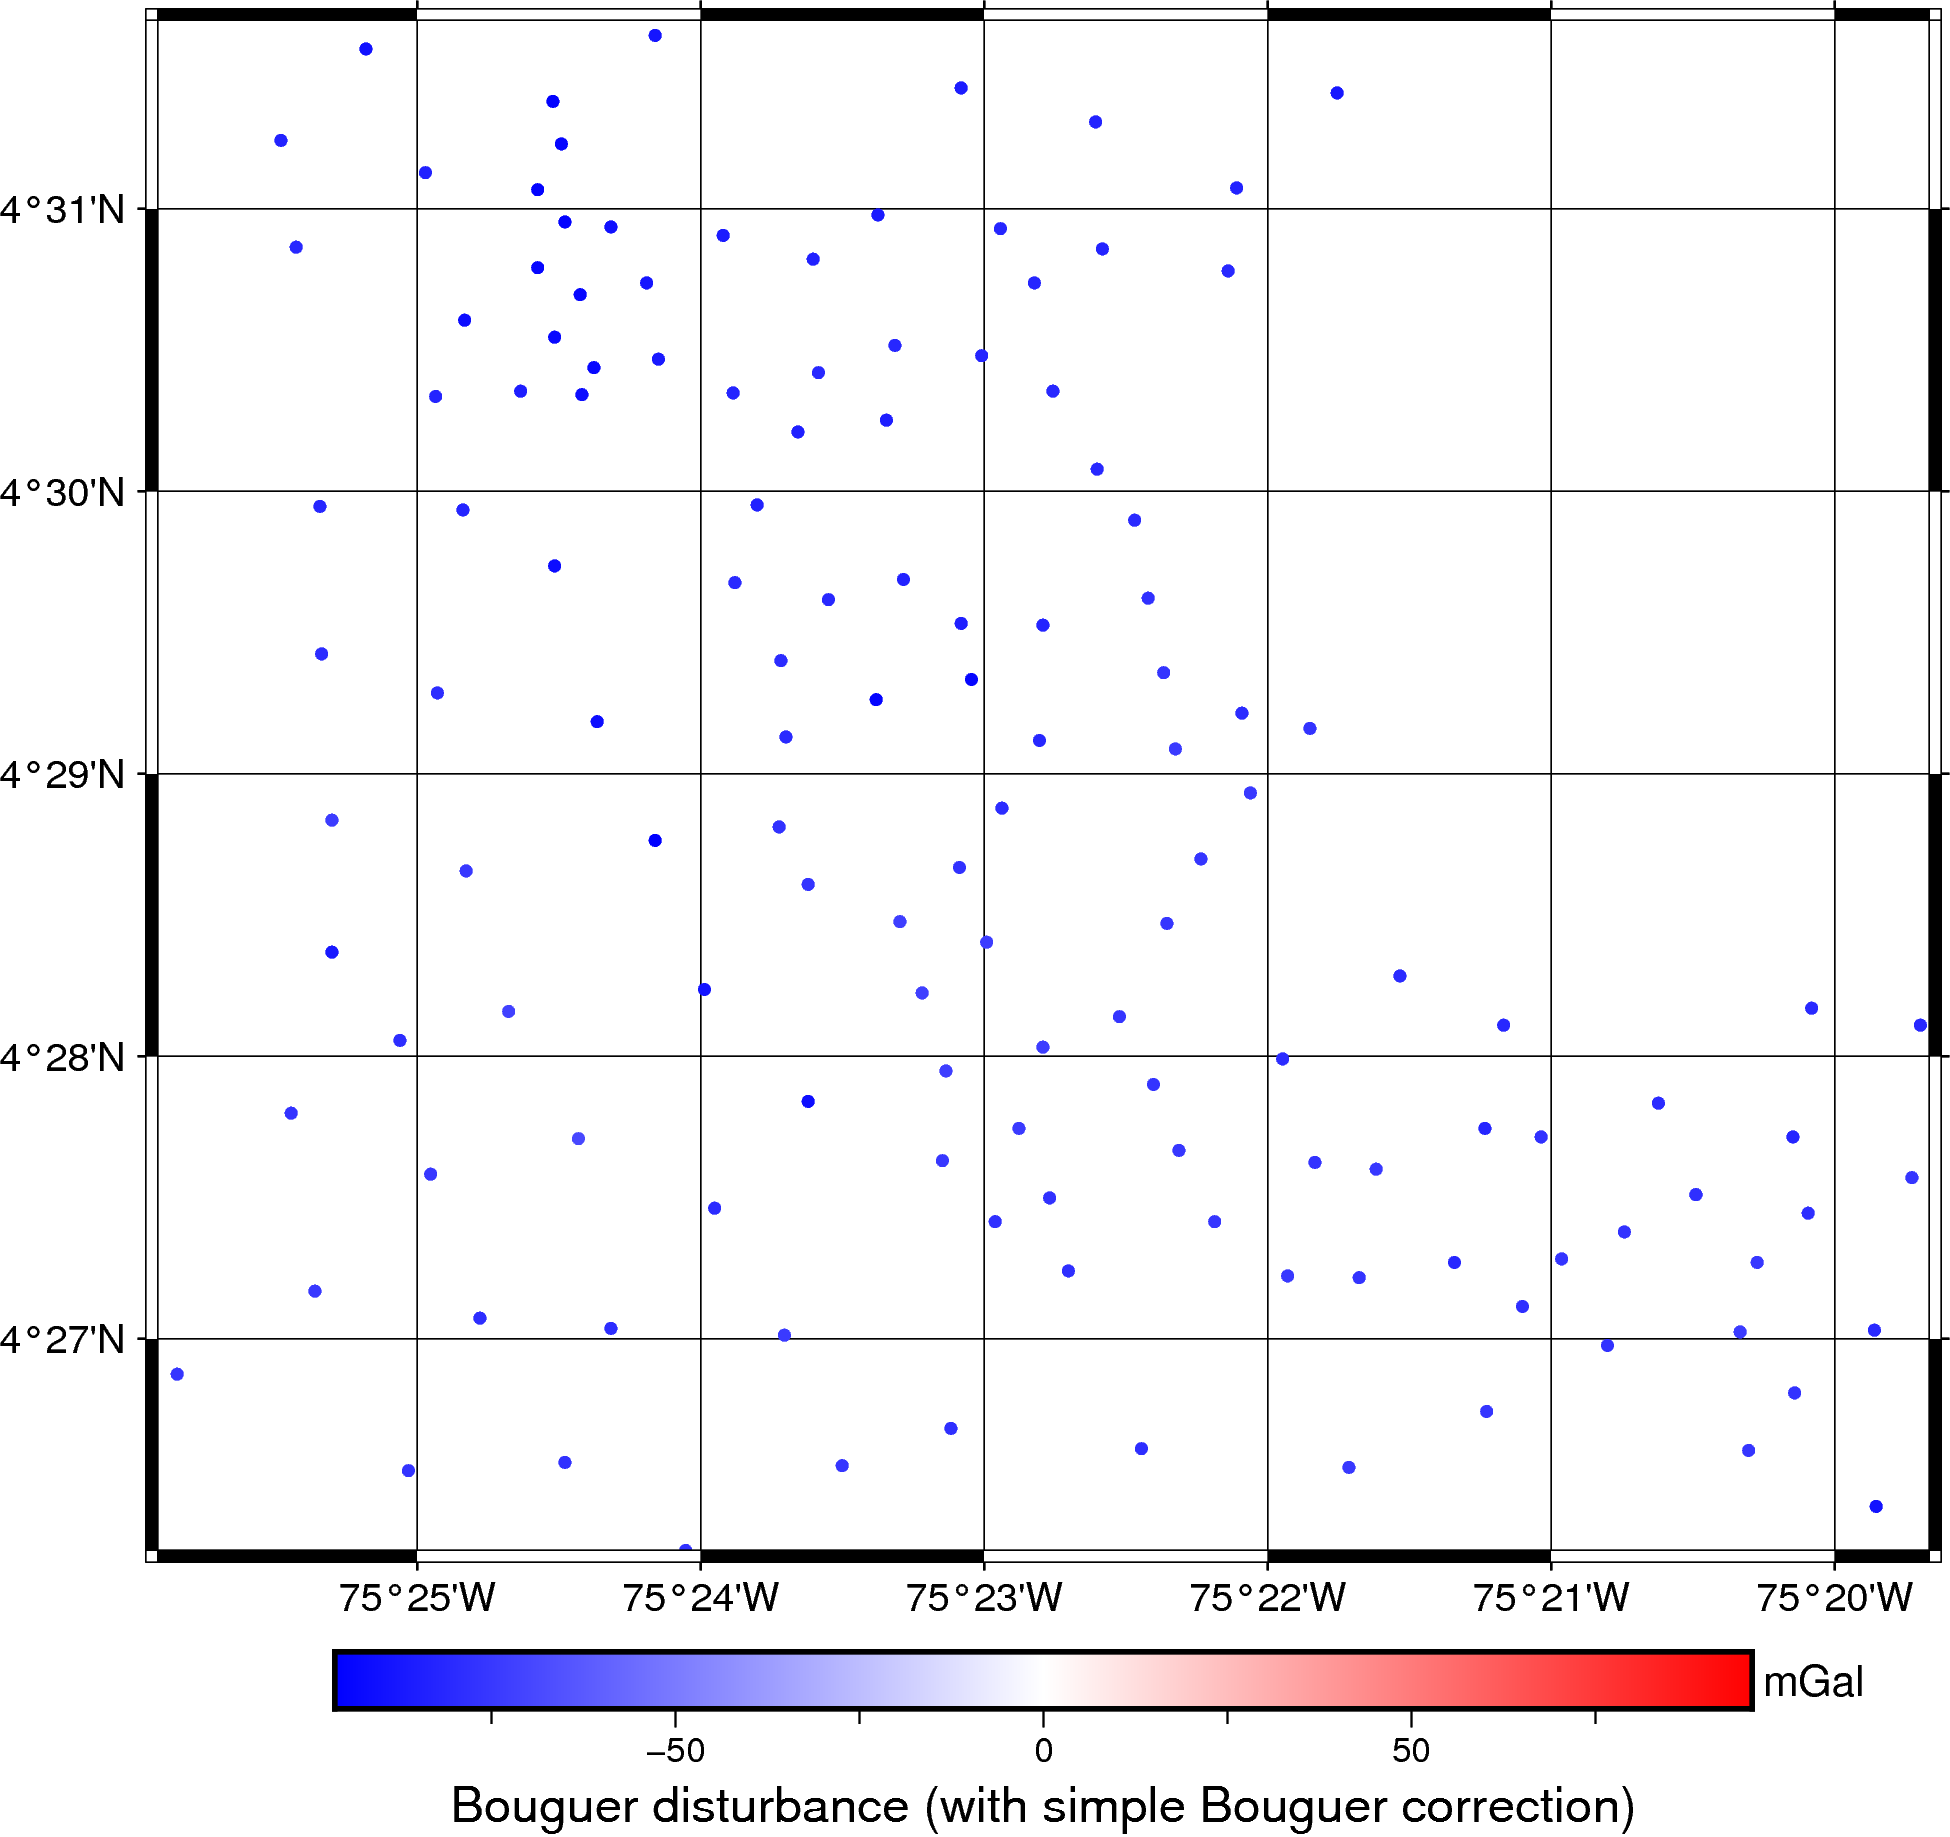

In [213]:
import ensaio
import harmonica as hm

Bouguer_disturbance = G_Disturbance - df['CB']


maxabs = vd.maxabs(Bouguer_disturbance)

fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.plot(
   x=lons,
   y=lats,
   fill=Bouguer_disturbance,
   cmap=True,
   style="c3p",
   projection="M15c",
   frame=['ag', 'WSen'],
)
fig.colorbar(cmap=True, frame=["a50f25", "x+lBouguer disturbance (with simple Bouguer correction)", "y+lmGal"])
fig.show()

In [214]:
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

Python version: 3.10.19 | packaged by conda-forge | (main, Oct 13 2025, 14:05:01) [MSC v.1944 64 bit (AMD64)]
Python executable: c:\Users\gabri\anaconda3\envs\volcan\python.exe


# Correccion de Terreno

In [215]:
import rioxarray as rioxr
import xarray as xr

# Ruta al archivo DEM
PATH_DEM = 'DEM_Correccion/DEM_CT_PROJECT_SGC.tif'

import geopandas as gpd
import verde as vd
import harmonica as hm
import pyproj

# 1) Carga DEM original (no recortes vacíos)
dem = rioxr.open_rasterio(PATH_DEM).squeeze(drop=True).load()

# Si viniera con 'band', quedarte con la primera y dejar 2D (y, x)
if "band" in dem.dims:
    dem = dem.isel(band=0)

# Ordenar ejes (Harmonica exige ejes ascendentes)
dem = dem.sortby("x").sortby("y")


if dem.rio.nodata is not None:
    dem = dem.where(dem != dem.rio.nodata)
dem = dem.astype("float32").sortby("x").sortby("y")

# 2) Reproyecta tus estaciones a CRS del DEM (ESRI:103599 / EPSG:9377 según tu archivo)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Long'], df['Lat']), crs="EPSG:4326")
gdf = gdf.to_crs(dem.rio.crs)
xs = gdf.geometry.x.values
ys = gdf.geometry.y.values


# 2.1) **Altura desde el DEM** (rápido y vectorizado)
H_from_DEM_m = dem.interp(x=("points", xs), y=("points", ys), method="nearest")
z_obs = H_from_DEM_m.values.astype(float)   # ← listo (ndarray)


# 3) Densidad: roca vs aire/agua
density = (np.where(dem.values >= 0.0, 2630.025, 1030.0 - 2630.025)).astype("float32")


# 4) Usar el método de los prismas para calcular la corrección de terreno (CT) en cada estación, con la densidad variable
prisms = hm.prism_layer(
    (dem.x.values, dem.y.values),
    surface=dem,
    reference=0.0,
    properties={"density": density},
)
df["CT"] = prisms.prism_layer.gravity((xs, ys, z_obs), field="g_z", progressbar=True)



df['CT']


df['Corr_terr_limpia']=  (G_Disturbance - df['CT'])
df


  0%|          | 0/136 [00:00<?, ?it/s]

,Station,Long,Lat,X,Y,Z,G_Obs,GRS1980_(gt),CA,AAL,dH_ref,CB,ABS,rho_Jung,CT,Corr_terr_limpia
0,93,-75.4080,4.4427,4732883.463,2049345.170,1802.569,977628.5013,978063.682117,-556.272793,121.091976,-433.739897,198.715399,-77.623423,2.630025,18.696839,102.395137
1,98,-75.3415,4.4585,4740260.711,2051069.569,2014.366,977621.7091,978063.902439,-621.633348,179.440009,-221.942897,222.063923,-42.623914,2.630025,20.828771,158.611238
2,1000,-75.4053,4.5156,4733205.458,2057405.449,2127.088,977552.7659,978064.705131,-656.419357,144.480125,-109.220897,234.490409,-90.010283,2.630025,17.745048,126.735077
3,1001,-75.4063,4.5073,4733091.517,2056492.891,1954.450,977583.5755,978064.587823,-603.143270,122.130947,-281.858897,215.458777,-93.327830,2.630025,17.729597,104.401350
4,1002,-75.4071,4.5116,4733001.529,2056965.559,1981.408,977578.0543,978064.648571,-611.462509,124.868238,-254.900897,218.430630,-93.562392,2.630025,17.475493,107.392745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3023,-75.3437,4.4639,4740019.008,2051673.049,2339.895,977519.8658,978063.977916,-722.091597,177.979481,103.586103,257.950275,-79.970794,2.630025,18.918074,159.061406
132,3024,-75.3415,4.4585,4740260.711,2051069.569,2014.666,977585.9545,978063.902439,-621.725928,143.777989,-221.642897,222.096995,-78.319006,2.630025,20.828771,122.949218
133,3025,-75.3457,4.4563,4739795.423,2050836.891,2008.001,977588.4678,978063.871714,-619.669109,144.265194,-228.307897,221.362245,-77.097051,2.630025,19.340023,124.925171
134,73124018,-75.4172,4.4422,4731859.783,2049294.485,1832.207,977623.5576,978063.675158,-565.419080,125.301522,-404.101897,201.982696,-76.681173,2.630025,18.763452,106.538070


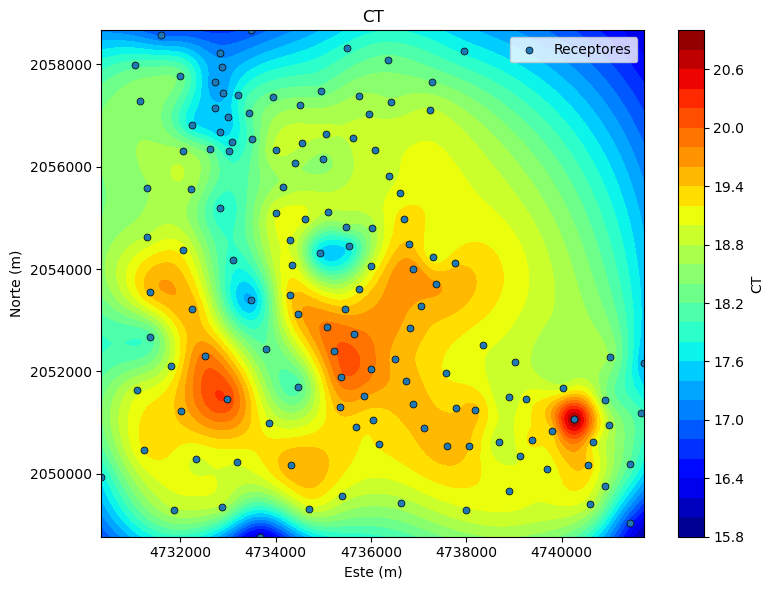

In [216]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator

data = df[['X', 'Y', 'CT']].dropna()

X = data['X'].to_numpy()
Y = data['Y'].to_numpy()
XY = data[['X', 'Y']].to_numpy()
CT = data['CT'].to_numpy()

nx, ny = 300, 300  # resolución (sube/baja según rendimiento)
xi = np.linspace(XY[:, 0].min(), XY[:, 0].max(), nx)
yi = np.linspace(XY[:, 1].min(), XY[:, 1].max(), ny)
Xi, Yi = np.meshgrid(xi, yi)
xg = np.column_stack([Xi.ravel(), Yi.ravel()])

# RBF Thin Plate Spline (muy “suave”, parecido a min-curv)
rbf = RBFInterpolator(XY, CT, kernel="thin_plate_spline", smoothing=1.0)
Z = rbf(xg).reshape(ny, nx)

plt.figure(figsize=(8,6))
im = plt.contourf(Xi, Yi, Z, levels=30, cmap='jet')


plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)

plt.colorbar(im, label='CT')
plt.scatter(df['X'], df['Y'], s=25, edgecolor='k', linewidth=0.5, label='Receptores')
plt.xlabel('Este (m)'); plt.ylabel('Norte (m)')
plt.title('CT')
plt.legend()
plt.tight_layout()
plt.show()

### Cálculo de la Anomalía de Bpuguer Total

In [217]:
df['ABT'] = df['G_Obs'] - df['GRS1980_(gt)'] - df['CA'] - df['CB'] + df['CT']
df

,Station,Long,Lat,X,Y,Z,G_Obs,GRS1980_(gt),CA,AAL,dH_ref,CB,ABS,rho_Jung,CT,Corr_terr_limpia,ABT
0,93,-75.4080,4.4427,4732883.463,2049345.170,1802.569,977628.5013,978063.682117,-556.272793,121.091976,-433.739897,198.715399,-77.623423,2.630025,18.696839,102.395137,-58.926585
1,98,-75.3415,4.4585,4740260.711,2051069.569,2014.366,977621.7091,978063.902439,-621.633348,179.440009,-221.942897,222.063923,-42.623914,2.630025,20.828771,158.611238,-21.795143
2,1000,-75.4053,4.5156,4733205.458,2057405.449,2127.088,977552.7659,978064.705131,-656.419357,144.480125,-109.220897,234.490409,-90.010283,2.630025,17.745048,126.735077,-72.265235
3,1001,-75.4063,4.5073,4733091.517,2056492.891,1954.450,977583.5755,978064.587823,-603.143270,122.130947,-281.858897,215.458777,-93.327830,2.630025,17.729597,104.401350,-75.598233
4,1002,-75.4071,4.5116,4733001.529,2056965.559,1981.408,977578.0543,978064.648571,-611.462509,124.868238,-254.900897,218.430630,-93.562392,2.630025,17.475493,107.392745,-76.086899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3023,-75.3437,4.4639,4740019.008,2051673.049,2339.895,977519.8658,978063.977916,-722.091597,177.979481,103.586103,257.950275,-79.970794,2.630025,18.918074,159.061406,-61.052720
132,3024,-75.3415,4.4585,4740260.711,2051069.569,2014.666,977585.9545,978063.902439,-621.725928,143.777989,-221.642897,222.096995,-78.319006,2.630025,20.828771,122.949218,-57.490235
133,3025,-75.3457,4.4563,4739795.423,2050836.891,2008.001,977588.4678,978063.871714,-619.669109,144.265194,-228.307897,221.362245,-77.097051,2.630025,19.340023,124.925171,-57.757028
134,73124018,-75.4172,4.4422,4731859.783,2049294.485,1832.207,977623.5576,978063.675158,-565.419080,125.301522,-404.101897,201.982696,-76.681173,2.630025,18.763452,106.538070,-57.917721


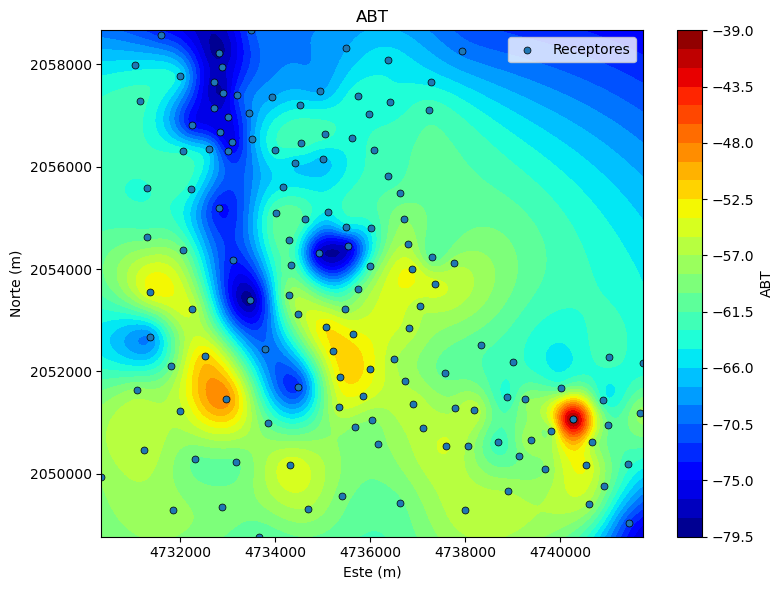

In [218]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator

data = df[['X', 'Y', 'ABT']].dropna()

X = data['X'].to_numpy()
Y = data['Y'].to_numpy()
XY = data[['X', 'Y']].to_numpy()
ABT = data['ABT'].to_numpy()

nx, ny = 300, 300  # resolución (sube/baja según rendimiento)
xi = np.linspace(XY[:, 0].min(), XY[:, 0].max(), nx)
yi = np.linspace(XY[:, 1].min(), XY[:, 1].max(), ny)
Xi, Yi = np.meshgrid(xi, yi)
xg = np.column_stack([Xi.ravel(), Yi.ravel()])

rbf = RBFInterpolator(XY, ABT, kernel="thin_plate_spline", smoothing=1.0)
Z = rbf(xg).reshape(ny, nx)

plt.figure(figsize=(8,6))
im = plt.contourf(Xi, Yi, Z, levels=30, cmap='jet')


plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)

plt.colorbar(im, label='ABT')
plt.scatter(df['X'], df['Y'], s=25, edgecolor='k', linewidth=0.5, label='Receptores')
plt.xlabel('Este (m)'); plt.ylabel('Norte (m)')
plt.title('ABT')
plt.legend()
plt.tight_layout()
plt.show()

In [219]:
# Crear un conjunto de fuentes profundas a una profundidad de 500 km.
deep_sources = hm.EquivalentSources(damping=1000, depth=500e3)
# Ajustar las fuentes al df
deep_sources.fit((df.X, df.Y, height_geometric_m), df['ABT'])

# Utiliza las fuentes para predecir el campo regional.
df = df.assign(
    ARegB=deep_sources.predict((df.X, df.Y, height_geometric_m))
)
# Calcular un campo residual (que es lo que queremos)

df = df.assign(
    AResB=df['ABT'] - df.ARegB
)

### Cálculo de la Anomalía Residual de Bouguer

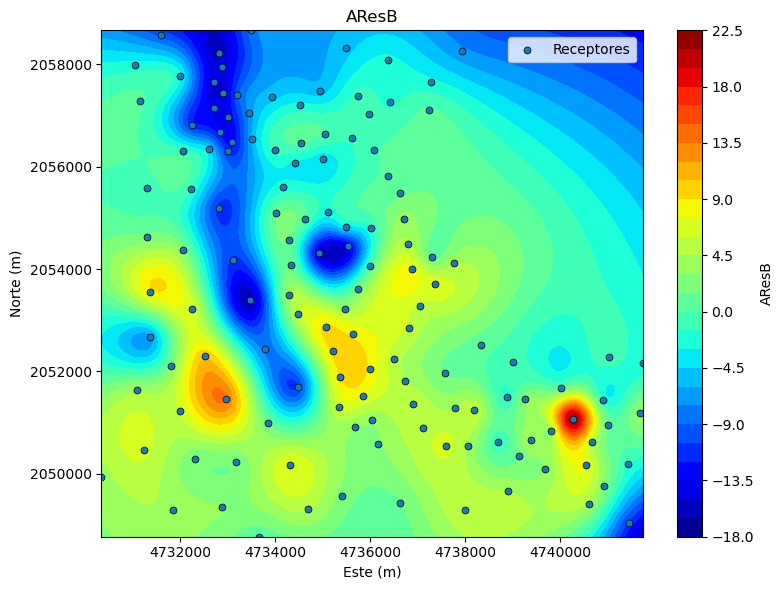

In [220]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator

data = df[['X', 'Y', 'AResB']].dropna()

X = data['X'].to_numpy()
Y = data['Y'].to_numpy()
XY = data[['X', 'Y']].to_numpy()
AResB = data['AResB'].to_numpy()

nx, ny = 300, 300  # resolución (sube/baja según rendimiento)
xi = np.linspace(XY[:, 0].min(), XY[:, 0].max(), nx)
yi = np.linspace(XY[:, 1].min(), XY[:, 1].max(), ny)
Xi, Yi = np.meshgrid(xi, yi)
xg = np.column_stack([Xi.ravel(), Yi.ravel()])

# RBF Thin Plate Spline (muy “suave”, parecido a min-curv)
rbf = RBFInterpolator(XY, AResB, kernel="thin_plate_spline", smoothing=1.0)
Z = rbf(xg).reshape(ny, nx)

plt.figure(figsize=(8,6))
im = plt.contourf(Xi, Yi, Z, levels=30, cmap='jet')


plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)

plt.colorbar(im, label='AResB')
plt.scatter(df['X'], df['Y'], s=25, edgecolor='k', linewidth=0.5, label='Receptores')
plt.xlabel('Este (m)'); plt.ylabel('Norte (m)')
plt.title('AResB')
plt.legend()
plt.tight_layout()
plt.show()

In [221]:
eqs = hm.EquivalentSources(damping=10, depth=10e3)
eqs.fit((df.X, df.Y, height_geometric_m), df['AResB'])

,damping,10
,points,None
,depth,10000.0
,block_size,None
,parallel,True
,dtype,'float64'


In [222]:
region = (df["Long"].min(), df["Long"].max(),
          df["Lat"].min(), df["Lat"].max())


In [223]:
projection = "M15c"


# Guardar archivo final

In [224]:
# Exportar el DataFrame a un archivo CSV
output_filename = 'Resultados_GravimetriaX.csv'
df.to_csv(output_filename, sep=';', index=False)
print(f"Archivo guardado como: {output_filename}")

Archivo guardado como: Resultados_GravimetriaX.csv
